### (a) ~  (b)

In [1]:
import numpy as np

Function which shuffles the list in uniformly random permutation

In [2]:
def shuffle_data(data):
    order = np.random.permutation(len(data['X']))
    # shuffle X and t in the same order
    for i in range(0, len(order)):
        X = data['X'][order]
        t = data['t'][order]
    # return the shuffled array
    return {'X': X, 't': t}

Given the data, fold number, and the fold to be selected as the validation set, split the data with the given requirements.<br/>
The function will distribute the fold as evenly as possible, the algorithm will is:
  1. `len(data) % num_folds` folds have `size len(data) // num_folds + 1`
  2. Other folds have size `len(data) // num_folds`

In [3]:
def split_data(data, num_folds, fold):
    X, t = data['X'], data['t']
    length = len(X) 
    first_batch = length % num_folds;
    
    # the longer fold is 1 unit longer than the short fold
    short_fold_len = length // num_folds
    long_fold_len = short_fold_len + 1
    
    # the fold can belong the short folds or the long folds
    if fold <= first_batch:
        start = (fold - 1) * long_fold_len
        end = start + long_fold_len
    else:
        start = (first_batch * long_fold_len) + (fold - first_batch - 1) * short_fold_len
        end = start + short_fold_len
    
    # construct the dataset
    test_data = {'X': X[start: end], 't': t[start: end]}
    rest_data = {'X': np.concatenate((X[:start], X[end:])), 't': np.concatenate((t[:start], t[end:]))}
    return test_data, rest_data

Train the model with **ridge regression** with weight $\hat{\mathbf{w}}_{MAP} = (\mathbf{X}^\top\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^\top\mathbf{t}$

In [4]:
def train_model(data, lambd):
    X, t = data['X'], data['t']
    X_T = X.transpose()
    # using the equation
    return np.linalg.inv((X_T @ X) + (lambd * np.identity(len(X[0])))) @ X_T @ t

Given the data and the estimator $\hat{\mathbf{w}}_{MAP}$, predict the label vector of the data

In [5]:
def predict(data, model):
    return data @ model

Calculate the average squared ***error*** loss based on model using the equation: $\lVert \mathbf{t} - \mathbf{X\hat{w}}\lVert^2/n$

In [6]:
def loss(data, model):
    X, t = data['X'], data['t']
    return (np.linalg.norm(t - (predict(X, model))) ** 2) / len(X)

In [7]:
def cross_validation(data, num_folds, lambd_seq):
    data = shuffle_data(data)
    cv_error = np.empty(shape=(len(lambd_seq),))
    
    # for each lambda in the lambda sequence, calculate the average squared error with cross validation
    for i in range(len(lambd_seq)):
        lambd = lambd_seq[i]
        cv_loss_lmd = 0.
        for fold in range(1, num_folds + 1):
            val_cv, train_cv = split_data(data, num_folds, fold)
            model = train_model(train_cv, lambd)
            cv_loss_lmd += loss(val_cv, model)
        cv_error[i] = cv_loss_lmd / num_folds
    return cv_error

Gathering the train and test data

In [8]:
data_train = {'X': np.genfromtxt('data_train_X.csv', delimiter = ','),
              't': np.genfromtxt('data_train_y.csv', delimiter = ',')}
data_test = {'X': np.genfromtxt('data_test_X.csv', delimiter = ','),
              't': np.genfromtxt('data_test_y.csv', delimiter = ',')}

### (c)
Generate lambda sequence using the number evenly spaced in the interval (0.02, 1.5)

In [9]:
lambd_seq = np.linspace(0.02, 1.5, num=50)

Calculate the train and test errors for each lambda in the lambda sequence

In [10]:
data_train = shuffle_data(data_train)
train_error, test_error = np.empty(shape=(len(lambd_seq),)), np.empty(shape=(len(lambd_seq),))
for i in range(len(lambd_seq)):
    lambd = lambd_seq[i]
    model = train_model(data_train, lambd)
    train_error[i], test_error[i] = loss(data_train, model), loss(data_test, model)

### (d)
Calculate five and ten fold cross validation errors

In [11]:
five_fold_cv_error = cross_validation(data_train, 5, lambd_seq)

In [12]:
ten_fold_cv_error = cross_validation(data_train, 10, lambd_seq)

Plot test, train, five, ten fold cross validation errors for each lambda

In [13]:
from matplotlib import pyplot as plt

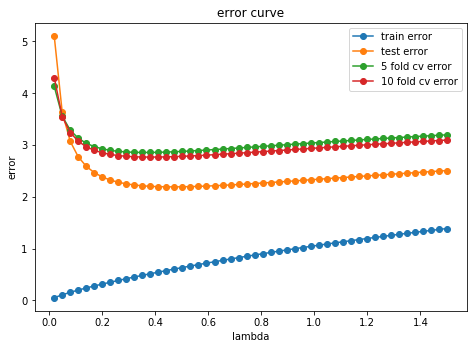

In [28]:
%matplotlib inline
x = np.array(lambd_seq)
y_train, y_test, y_five_cv, y_ten_cv = train_error, test_error, five_fold_cv_error, ten_fold_cv_error
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(x, y_train, '-o', label="train error")
ax.plot(x, y_test, '-o', label="test error")
ax.plot(x, y_five_cv, '-o', label="5 fold cv error")
ax.plot(x, y_ten_cv, '-o', label="10 fold cv error")
ax.set_title("error curve")
ax.set_xlabel("lambda")
ax.set_ylabel("error")
plt.legend()

In [20]:
ten_fold_min_lambd = lambd_seq[np.argmin(y_ten_cv)];

In [21]:
five_fold_min_lambd = lambd_seq[np.argmin(y_five_cv)];

In [22]:
min_lambd = min(ten_fold_min_lambd, five_fold_min_lambd)

In [23]:
min_lambd

0.3522448979591837

### Comment
The lambda proposed by the plot is the mininum between the argmin of 5 and 10 fold cross validation error which is about 0.352. The argmin of train and test error are not proposed since they don't have a valid validation set.

According to the plot, the model trained with training data directly is overfitting. Since the loss of prediciting test data with this model is much larger than the training error.

The trainning error is increasing as lambda increases, since as lambda increases, the model is affected more by the regularizer. Initially, the error should be the minimum average squared error, but the regularizer penalize the the loss more and more as the lambda increases, thats why the training error increases.

The cross validation method reduces the extend of over fitting of the model. It can be shown by the fact that the shape of the cross validation error curve is very similar to the actual test error curve.